In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import psycopg2
import pandas as pd
import seaborn as sns

from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import mean_squared_error, median_absolute_error
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet, ElasticNetCV

from joblib import dump, load

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

conn_dict = {'host': 'localhost',
        'dbname': 'insight',
        'user': os.getenv('PG_USER'),
        'password': os.getenv('PG_PASSWORD')}

with psycopg2.connect(**conn_dict) as conn, conn.cursor() as cur:
    cur.execute('SELECT * FROM patterns3')
    res = cur.fetchall()
    cols = [desc[0] for desc in cur.description]

df = pd.DataFrame(res, columns=cols)

In [2]:
df.loc[:, 'pubyear'] = df.published.apply(lambda x: x.year if pd.notnull(x) else None)
df.loc[:, 'buttoned_mod'] = df[['attribute_buttoned', 'attribute_buttonholes']].max(axis=1)

In [3]:
patt_ann = df[pd.notnull(df.pubyear)].groupby('pubyear').count()\
                                     .reset_index()[['pubyear', 'comments_count']]\
                                     .rename(columns={'comments_count':'n_patterns'})
patt_ann = patt_ann[patt_ann.pubyear.isin(np.arange(2000, 2019))]

([<matplotlib.axis.XTick at 0x1a3e5e3450>,
 <a list of 7 Text xticklabel objects>)

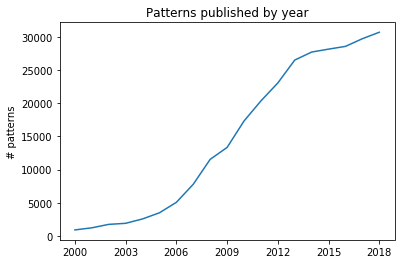

In [5]:
fig, ax = plt.subplots()
sns.lineplot(x="pubyear", y="n_patterns", data=patt_ann, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('# patterns')
ax.set_title('Patterns published by year')
plt.xticks(np.arange(2000, 2019, 3))
#fig.savefig('pattern_by_year.png')

In [4]:
proj_ann = df[pd.notnull(df.pubyear)].groupby('pubyear').count()\
                                     .reset_index()[['pubyear', 'comments_count']]\
                                     .rename(columns={'comments_count':'n_patterns'})
patt_ann = patt_ann[patt_ann.pubyear.isin(np.arange(2000, 2019))]

In [5]:
attribute_cols = [a for a in df.columns if a.startswith('attribute_')]
att_df = df[attribute_cols].sum(axis=0).reset_index().sort_values(0, ascending=False)
att_df.columns = ['attribute', 'pattern_count']
att_df.loc[:, 'pattern_share'] = att_df.pattern_count / df.shape[0]
att_df = att_df[att_df.pattern_share >= 0.05]

In [6]:
attribute_cols = list(att_df.attribute[att_df.pattern_share >= 0.05])
attribute_cols.remove('attribute_written_pattern')
attribute_cols.remove('attribute_buttonholes')
attribute_cols.remove('attribute_buttoned')

In [7]:
needles_cols = [n for n in df.columns if n.startswith('needle')]
needles_df = df[needles_cols].sum(axis=0).reset_index().sort_values(0, ascending=False)
needles_df.columns = ['needle', 'pattern_count']
needles_df.loc[:, 'pattern_share'] = needles_df.pattern_count / df.shape[0]
needles_df = needles_df[needles_df.pattern_share >= 0.01]
needles_cols = list(needles_df.needle[needles_df.pattern_share >= 0.01])
needles_cols

['needles_us_6',
 'needles_us_7',
 'needles_us_4',
 'needles_us_8',
 'needles_us_5',
 'needles_us_3',
 'needles_us_2h',
 'needles_us_10',
 'needles_us_9',
 'needles_us_1h',
 'needles_us_2',
 'needles_us_1',
 'needles_us_11',
 'needles_us_10h',
 'needles_us_13',
 'needles_us_15',
 'needles_us_0']

In [14]:
#numeric_cols = ['projects_count', 'queued_projects_count', 'rating_average','comments_count',
#                'difficulty_average','num_photos', 'author_pattern_count','author_favorites_count']

numeric_cols = ['difficulty_average','num_photos']
cat_cols = ['pattern_type','yarn_weight']

attribute_cols = ['buttoned_mod',
                  'attribute_adult', #
                  'attribute_female',#
                  'attribute_worked_flat',#
                  'attribute_worked_in_the_round',#
                  'attribute_chart',#
                  'attribute_bottom_up',#
                  'attribute_one_piece',#
                  'attribute_unisex',#
                  'attribute_seamed',#
                  'attribute_lace',#
                  'attribute_teen',#
                  'attribute_ribbed_ribbing',#
                  'attribute_textured',#
                  'attribute_cables',#
                  'attribute_stripes_colorwork',#
                  'attribute_top_down',#
                  'attribute_child',#
                  'attribute_long',#
                  'attribute_stranded',#
                  'attribute_baby',#
                  'attribute_positive_ease',#
                  'attribute_has_schematic',#
                  'attribute_male',#
                  'attribute_eyelets',#
                  'attribute_toddler', #
                  'attribute_fitted',#
                  'attribute_short_rows']

needles_cols = ['needles_us_6',
                'needles_us_7',
                'needles_us_4',
                'needles_us_8',
                'needles_us_5',
                'needles_us_3',
                'needles_us_2h',
                'needles_us_10',
                'needles_us_9',
                'needles_us_1h',
                'needles_us_2',
                'needles_us_1',
                'needles_us_11',
                'needles_us_10h',
                'needles_us_13',
                'needles_us_15',
                'needles_us_0']

In [15]:
df2 = df[pd.notnull(df.price) & (df.currency == 'USD') & (df.price <= 17)]

df2.loc[:, 'price'] = df2.price.apply(lambda x: float(x) if pd.notnull(x) else 0)

/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [16]:
df2 = df2[['price'] + needles_cols + attribute_cols + numeric_cols + cat_cols].dropna()

In [22]:
X = df2[needles_cols + attribute_cols + numeric_cols + cat_cols]
y = df2['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'X_train shape = {X_train.shape}')
from joblib import load
clf = load("/Users/jason/Desktop/stage2_reduced_v0.joblib")

X_train shape = (103038, 49)


In [18]:
df2.loc[:, 'pred_price'] = list(clf.predict(X))

/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype bool, int64, object were all converted to float64 by StandardScaler.
  res = transformer.transform(X)


In [19]:
df2.head()

,price,needles_us_6,needles_us_7,needles_us_4,needles_us_8,needles_us_5,needles_us_3,needles_us_2h,needles_us_10,needles_us_9,...,attribute_male,attribute_eyelets,attribute_toddler,attribute_fitted,attribute_short_rows,difficulty_average,num_photos,pattern_type,yarn_weight,pred_price
8,14.0,False,False,True,False,False,False,False,False,False,...,False,False,False,False,True,4.904365904365904,9,shawl-wrap,Fingering,6.3270
14,5.0,True,False,False,False,False,False,False,False,False,...,True,True,False,False,True,2.28,14,shawl-wrap,Fingering,5.3348
18,7.0,False,False,True,False,False,False,False,False,False,...,False,True,False,False,False,2.7873741285824942,13,shawl-wrap,Fingering,6.7848
20,5.0,False,True,False,False,False,False,False,False,False,...,False,True,False,False,False,2.275268817204301,8,shawl-wrap,Fingering,5.1750
21,6.0,True,False,False,False,True,False,False,False,False,...,False,False,False,False,False,2.4852459016393444,17,shawl-wrap,Fingering,6.2249


/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype bool, int64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


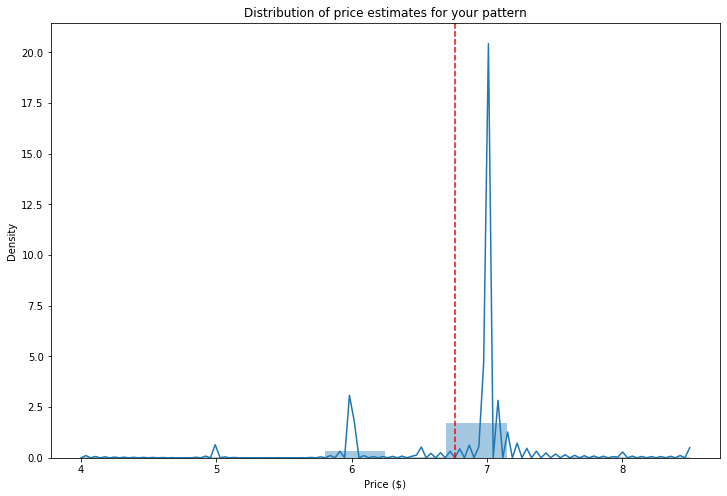

In [20]:
#clf.named_steps['randomforestregressor'].estimators_
#clf.predict(X)
#X.iloc[2]
X.shape
X_trans = clf.named_steps['columntransformer'].fit_transform(X)
x = X_trans[2]
yest = [clfest.predict(x.reshape(1,-1))[0] for clfest in clf.named_steps['randomforestregressor'].estimators_]
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
sns.distplot(yest, ax=ax, hist=True)
ax.set_xlabel('Price ($)')
ax.set_ylabel('Density')
ax.set_title('Distribution of price estimates for your pattern')
ax.axvline(np.mean(yest), linestyle='--', color='red')
#X.iloc[1].values.reshape(-1, 1).shape
#xx = dict(zip(X.columns, X.iloc[1,:].values))
#clf.named_steps['columntransformer'].fit_transform(pd.DataFrame(xx, index=[0]))


In [46]:
print(f'Model RMSE: {np.sqrt(mean_squared_error(y_test, clf.predict(X_test)))}')
print(f'Model MAE: {median_absolute_error(y_test, clf.predict(X_test))}')

len(np.abs(y_test - clf.predict(X_test)/y_test))
X_test.shape

/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype bool, int64, object were all converted to float64 by StandardScaler.
  res = transformer.transform(X)


Model RMSE: 0.8354262867342235


/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype bool, int64, object were all converted to float64 by StandardScaler.
  res = transformer.transform(X)


Model MAE: 0.33009999999999984


/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/pipeline.py:605: DataConversionWarning: Data with input dtype bool, int64, object were all converted to float64 by StandardScaler.
  res = transformer.transform(X)


(25760, 50)

In [47]:
z = df2.groupby('pattern_type').agg({'price': 'median'}).reset_index()
median_map = dict(zip(z.pattern_type, z.price))
z2 = df2.groupby('pattern_type').agg({'price': 'mean'}).reset_index()
mean_map = dict(zip(z2.pattern_type, z2.price))
X_test.loc[:, 'cat_median'] = X_test.pattern_type.apply(lambda x: median_map[x])
X_test.loc[:, 'cat_mean'] = X_test.pattern_type.apply(lambda x: mean_map[x])

/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/jason/anaconda3/envs/insight/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [49]:
print(f'RMSE of median benchmark: {np.sqrt(mean_squared_error(X_test.cat_median, y_test))}')
print(f'RMSE of mean benchmark: {np.sqrt(mean_squared_error(X_test.cat_mean, y_test))}')
print(f'MAE of median benchmark: {median_absolute_error(X_test.cat_median, y_test)}')
print(f'MAE of mean benchmark: {median_absolute_error(X_test.cat_mean, y_test)}')

RMSE of median benchmark: 1.5286292447851515
RMSE of mean benchmark: 1.5146113442818279
MAE of median benchmark: 1.0
MAE of mean benchmark: 0.8281166628986281


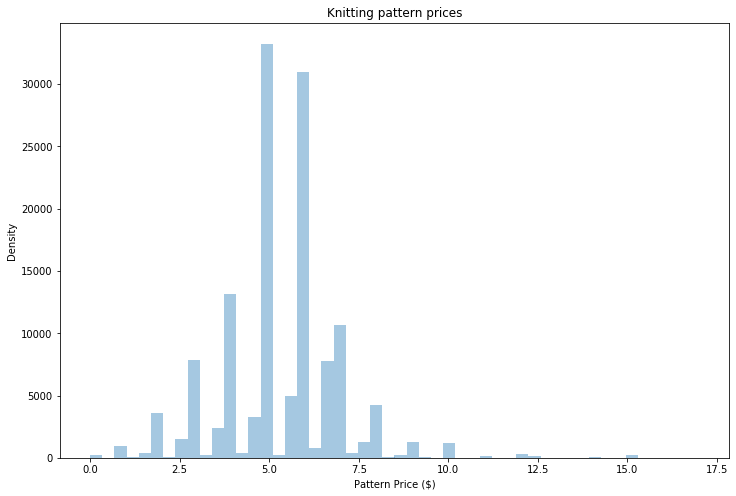

In [58]:
fig, ax = plt.subplots()
fig.set_size_inches(12,8)
sns.distplot(df2.price, kde=False)
ax.set_xlabel("Pattern Price ($)")
ax.set_ylabel("Density")
ax.set_title('Knitting pattern prices')
plt.savefig('pattern_prices.png')

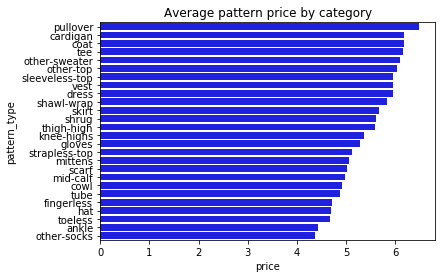

In [71]:
s = df2.groupby('pattern_type').agg({'price': lambda x: np.round(np.mean(x), 2)})\
.reset_index().sort_values('price', ascending=False)

fig, ax = plt.subplots()
sns.barplot(x="price", y="pattern_type", data=s, color="b", ax=ax)
ax.set_title('Average pattern price by category')
fig.savefig('average_prices.png')